D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in greater_equal
D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in less_equal
D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:176: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


'\nimg = cv2.imread("./testImage/test6.jpg")\nout1 = mag_threshold(img)\nout2 = abs_sobel_threshold(img)\nout3 = dir_threshold(img)\nout4 = hls_thresh(img)\nimgOut, abs_bin, mab_bin, dir_bin, hls_bin = combined_threshold(img)\nplt.figure(figsize = (30, 30))\nplt.title(\'calibration\')\nplt.subplot(1, 5, 1)\nplt.imshow(out1)\nplt.subplot(1, 5, 2)\nplt.imshow(out2)\nplt.subplot(1, 5, 3)\nplt.imshow(out3)\nplt.subplot(1, 5, 4)\nplt.imshow(out4)\nplt.subplot(1, 5, 5)\nplt.imshow(imgOut)\nplt.axis(\'off\')\nimgOut_size = (imgOut.shape[1], imgOut.shape[0])\nbinary_warped = cv2.warpPerspective(imgOut, m, imgOut_size, flags=cv2.INTER_LINEAR)\nundist = cv2.imread(\'undist6.jpg\')\nline_fit_and_draw_line(binary_warped)\n'

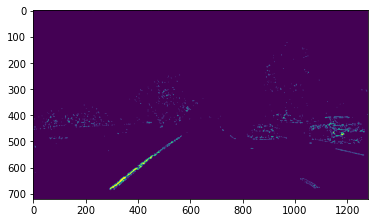

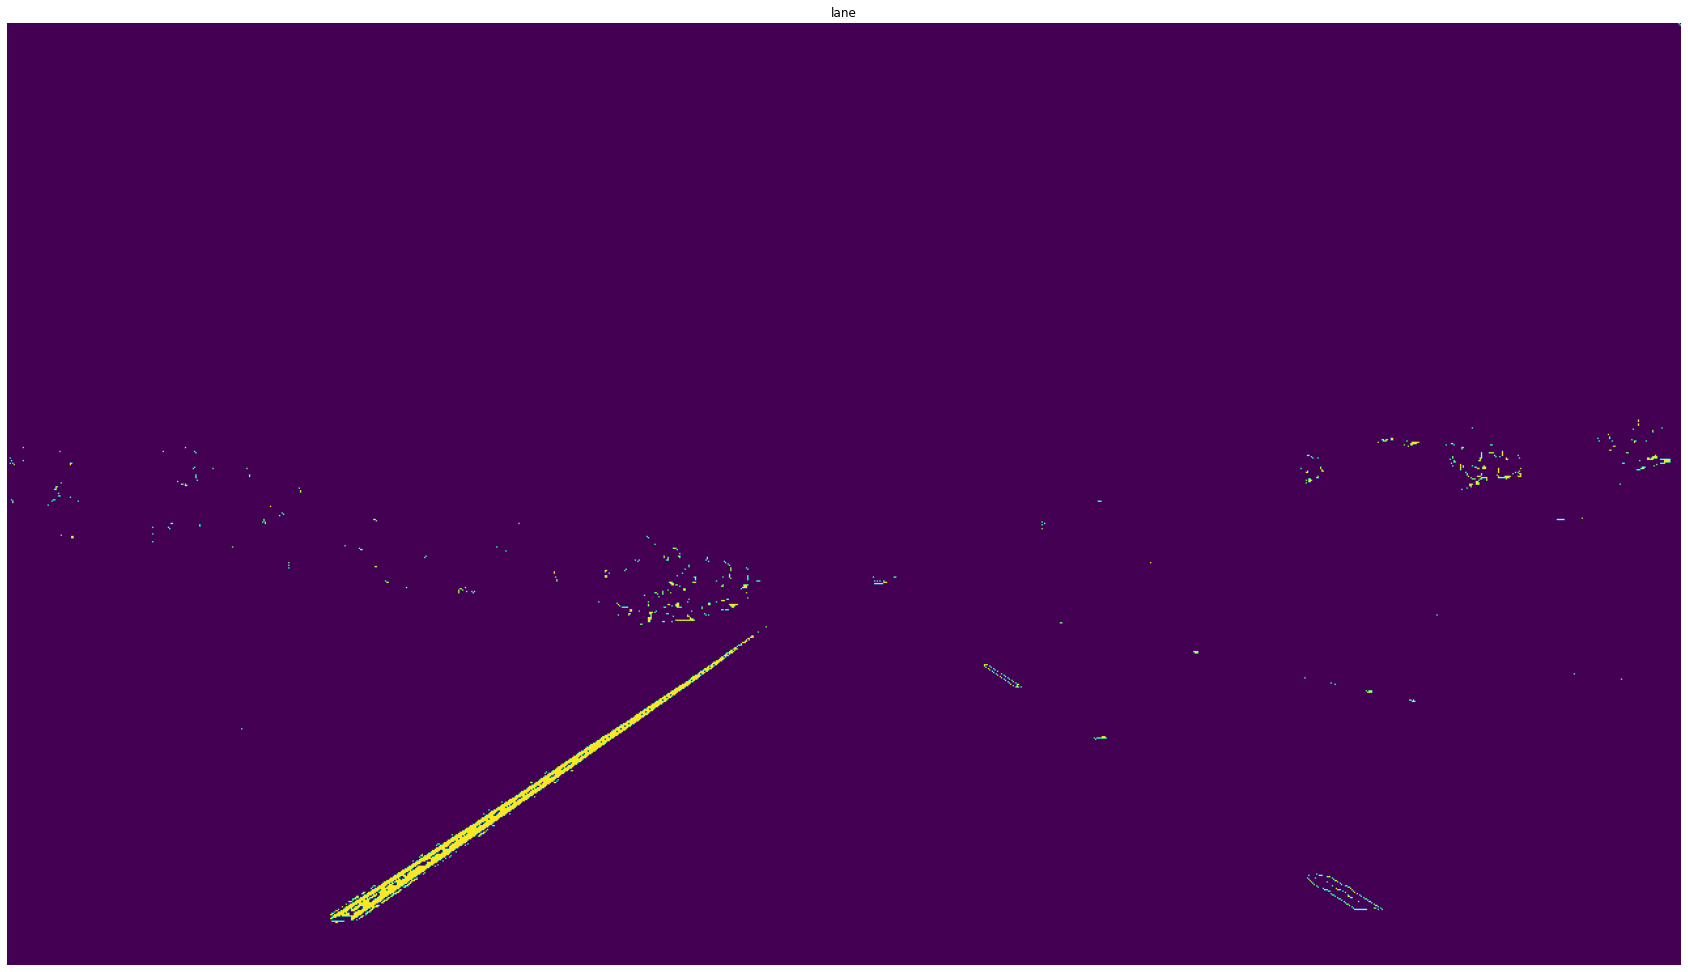

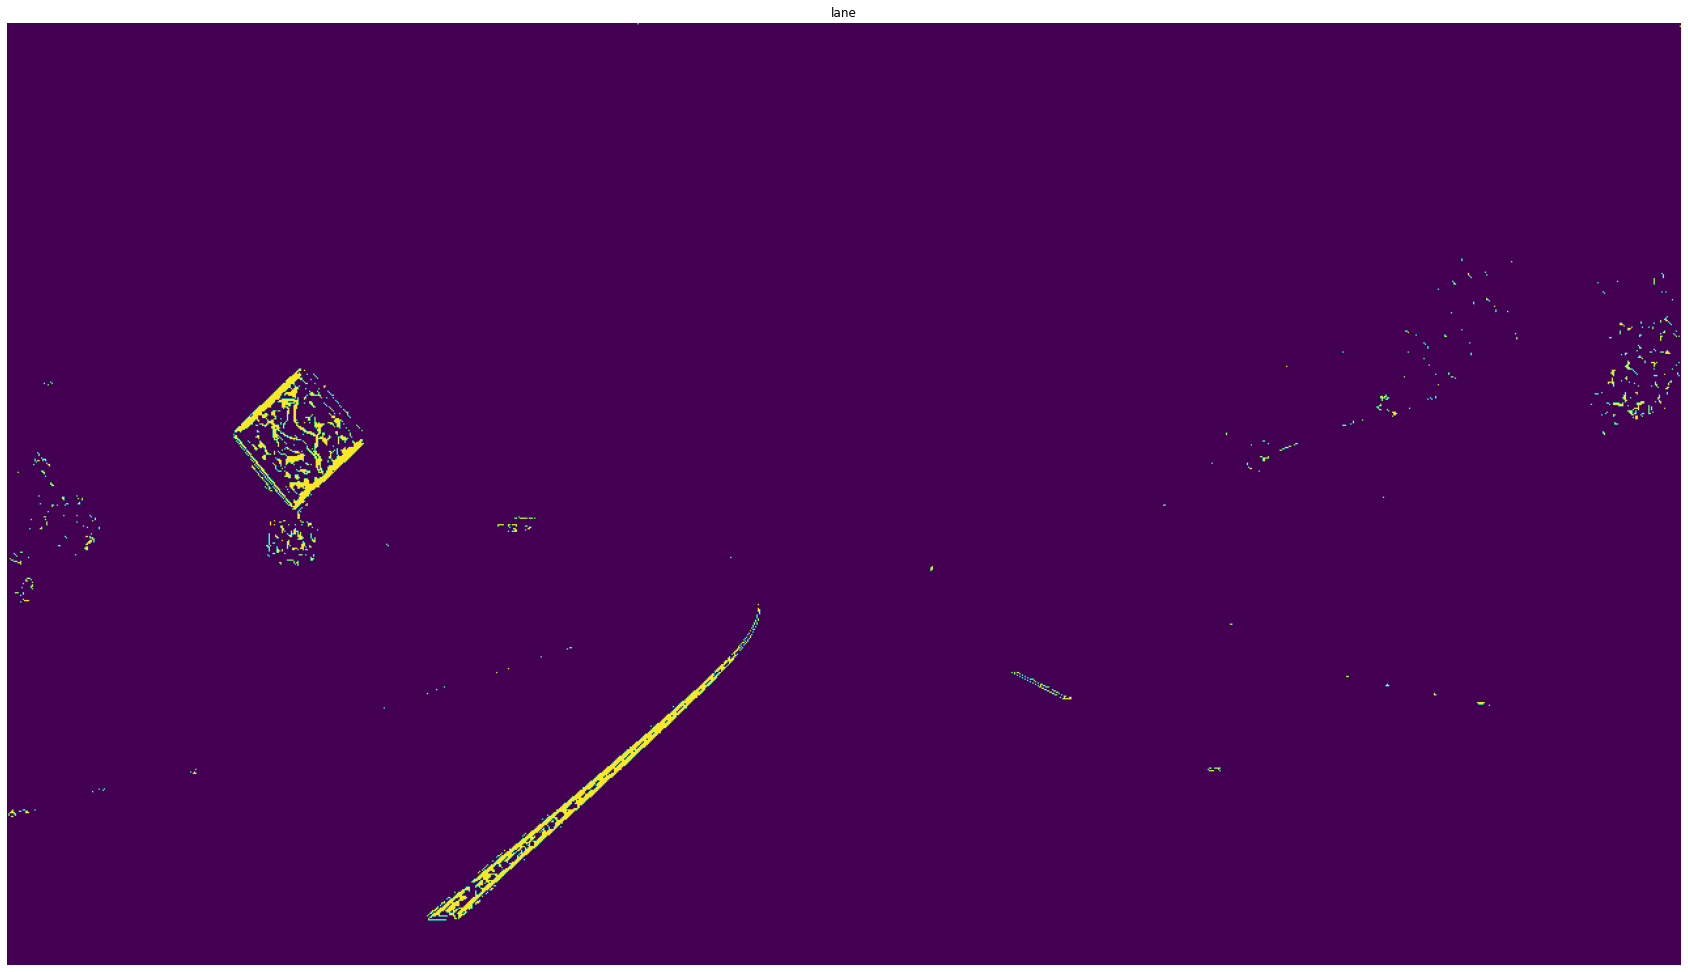

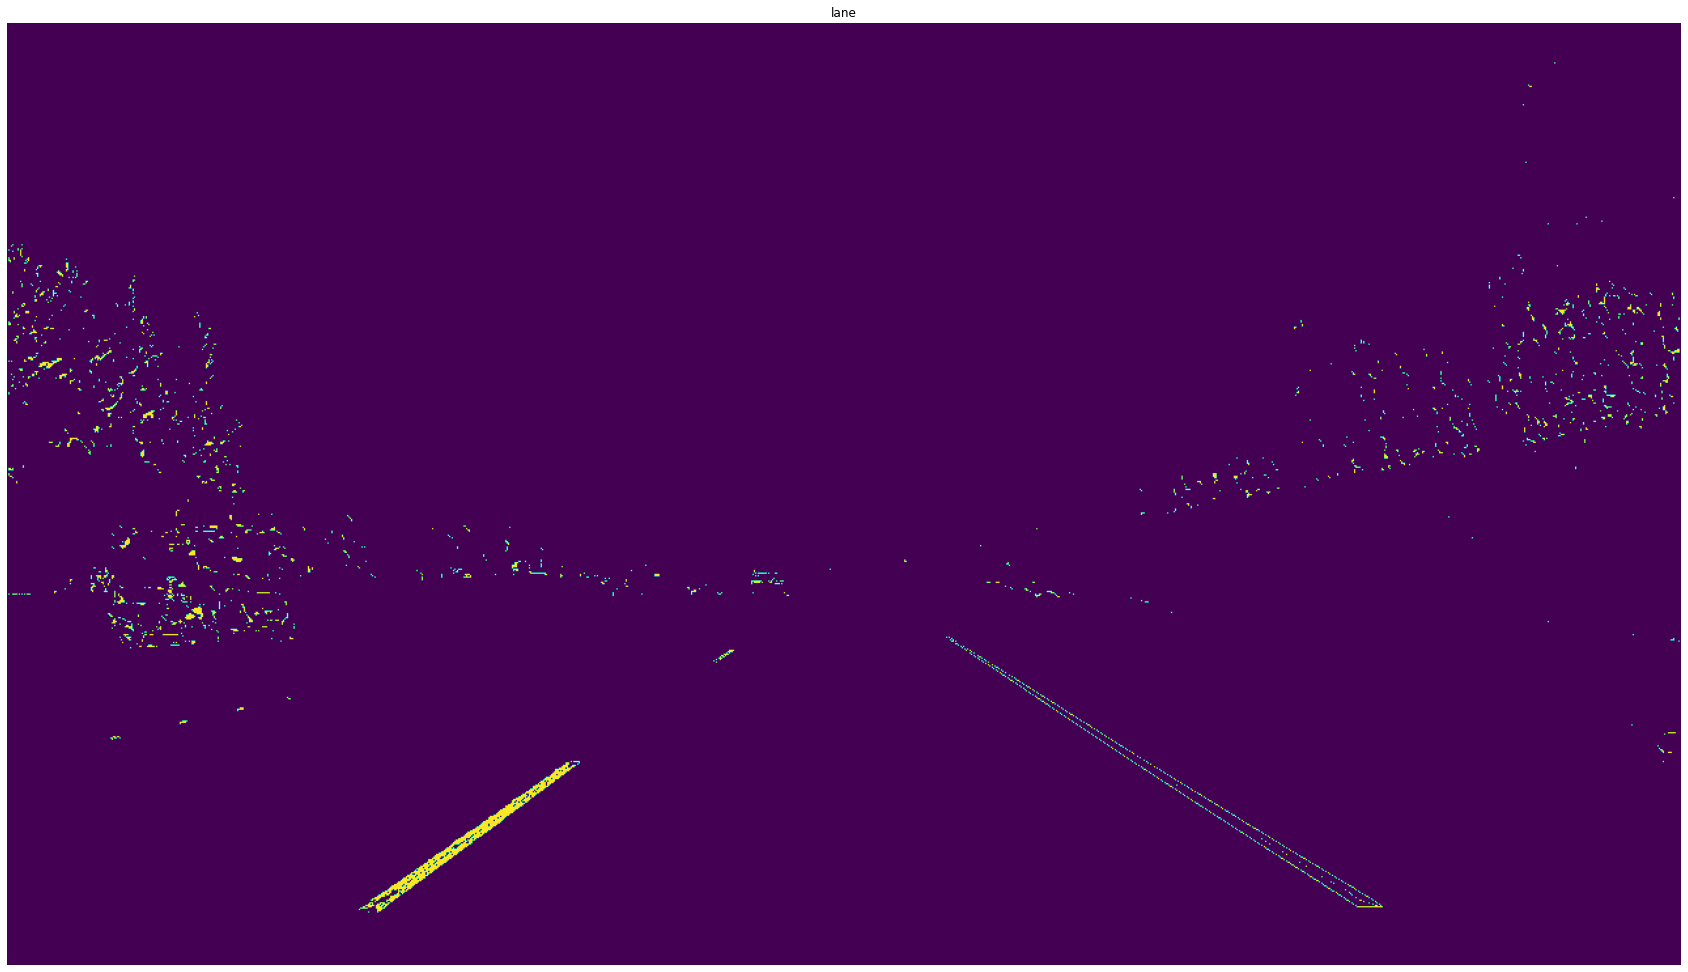

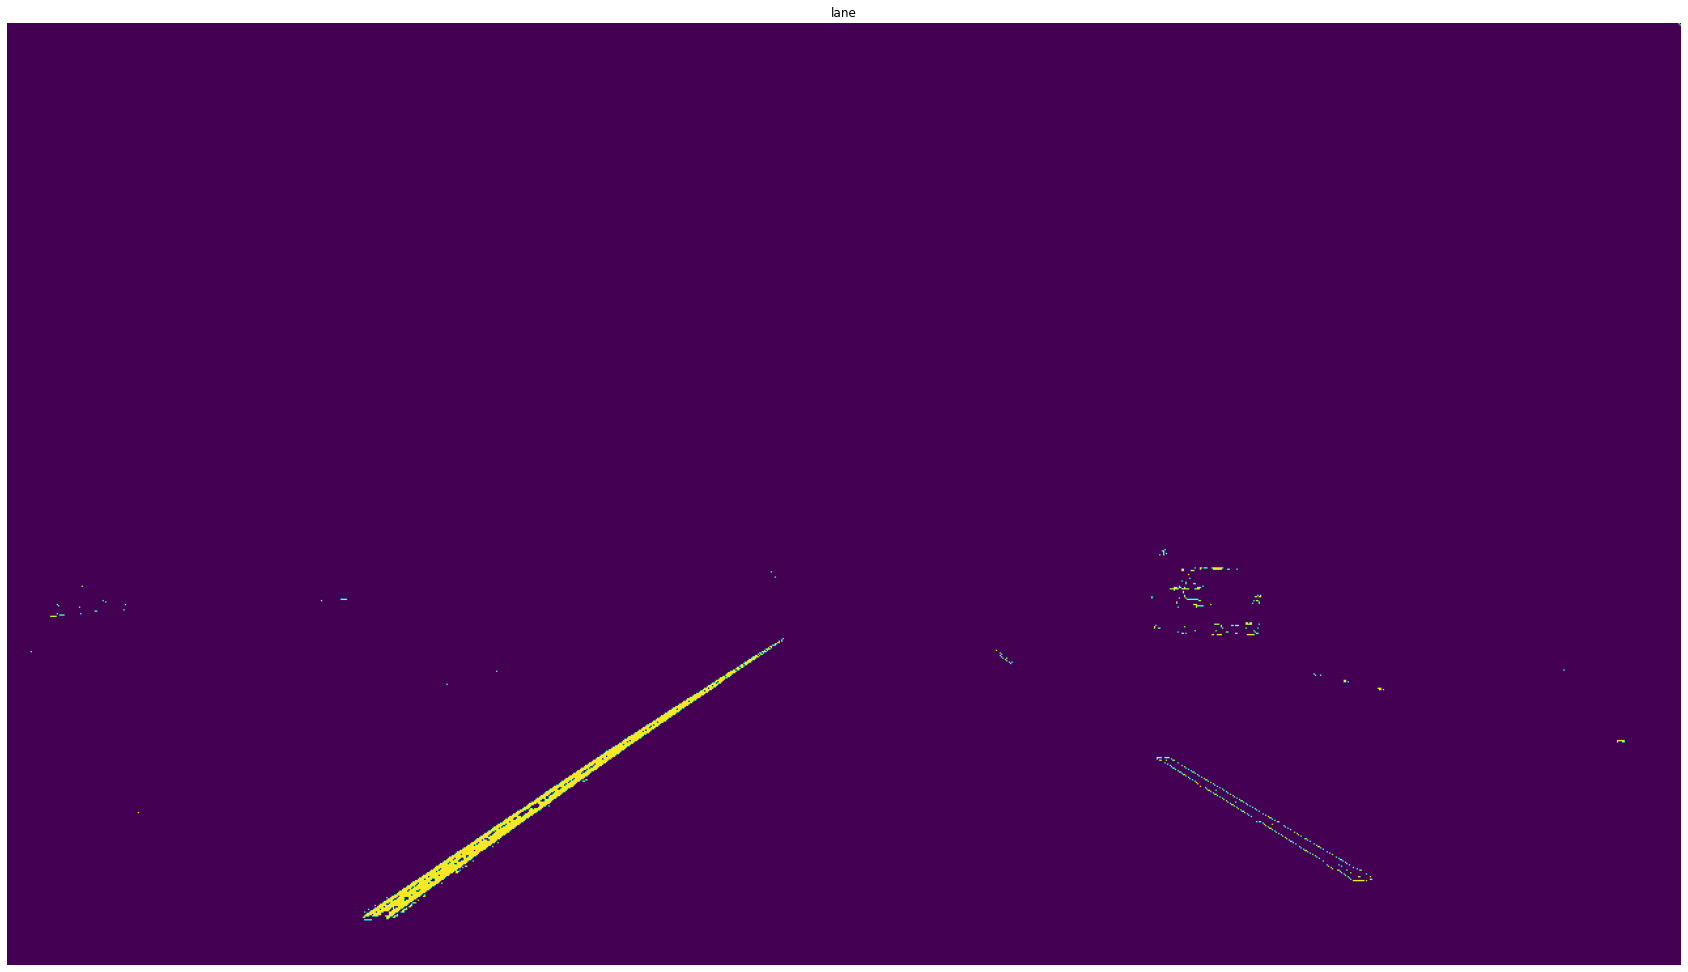

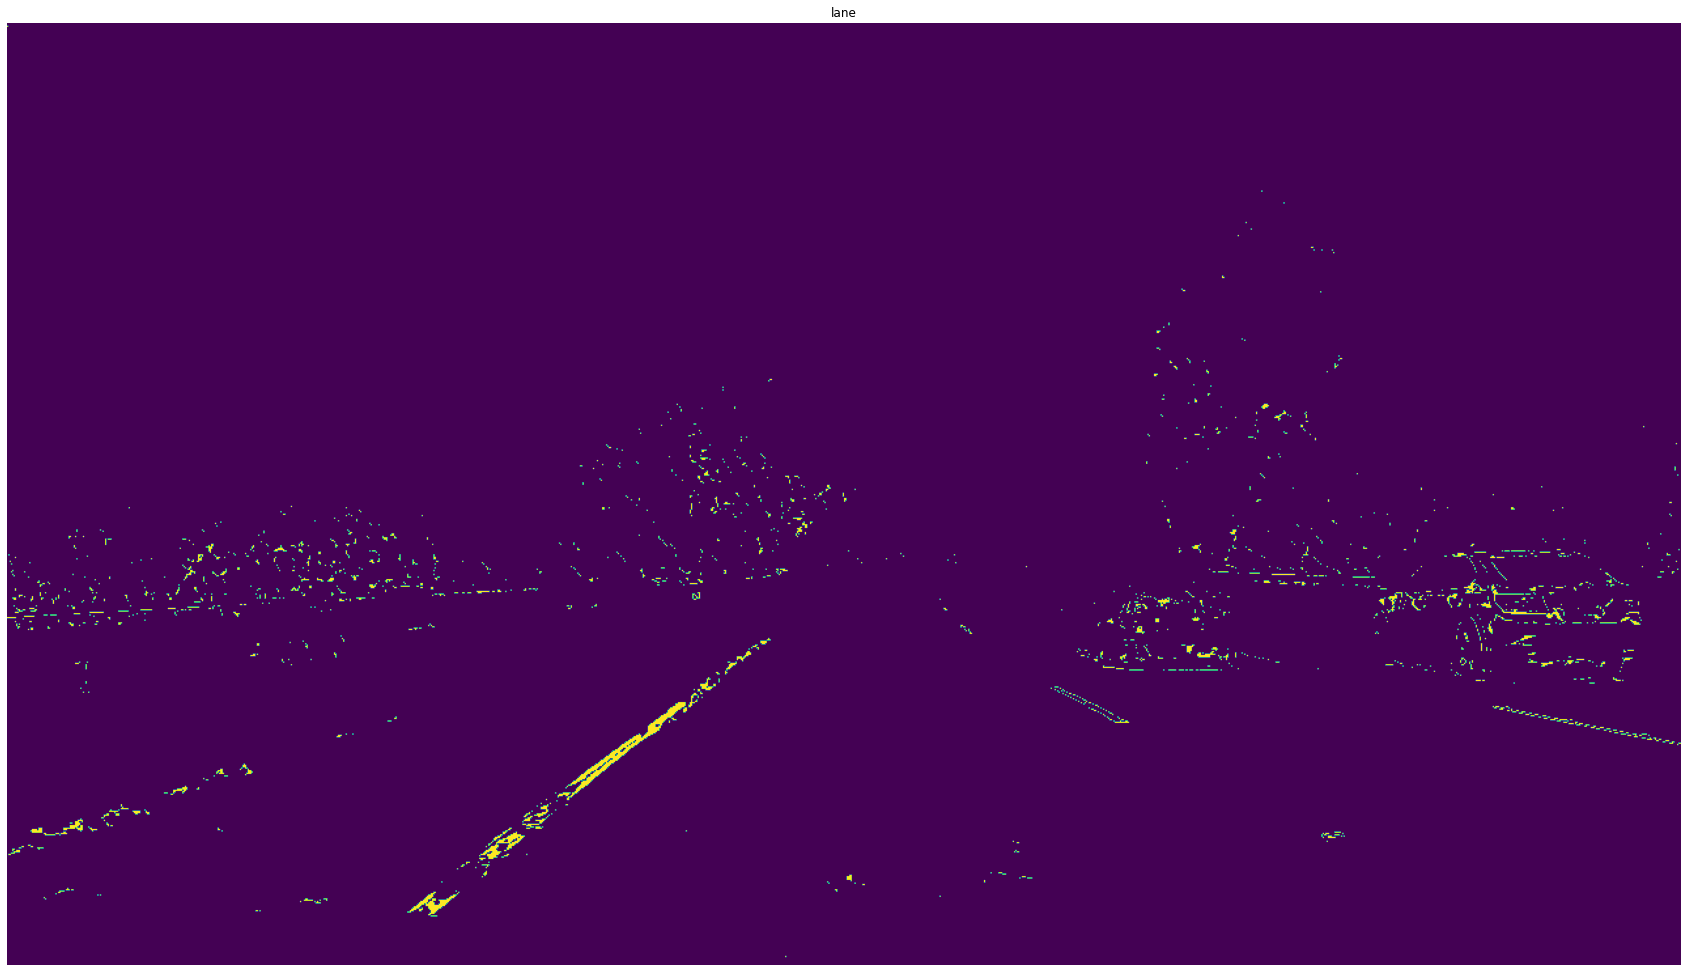

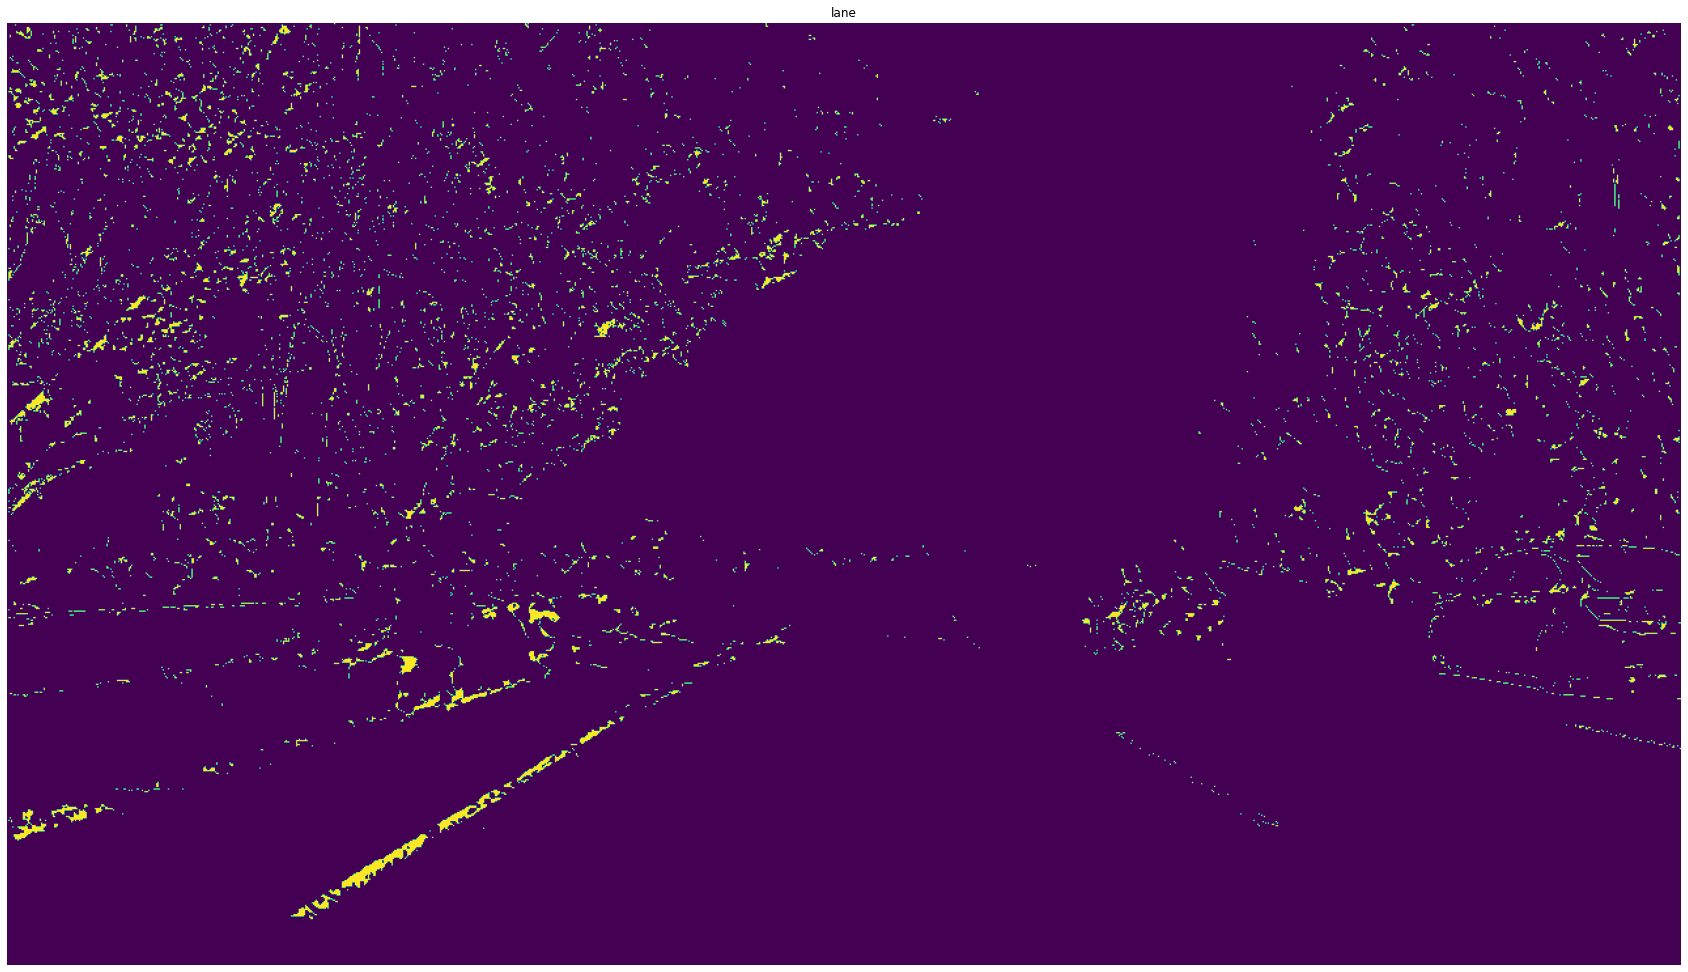

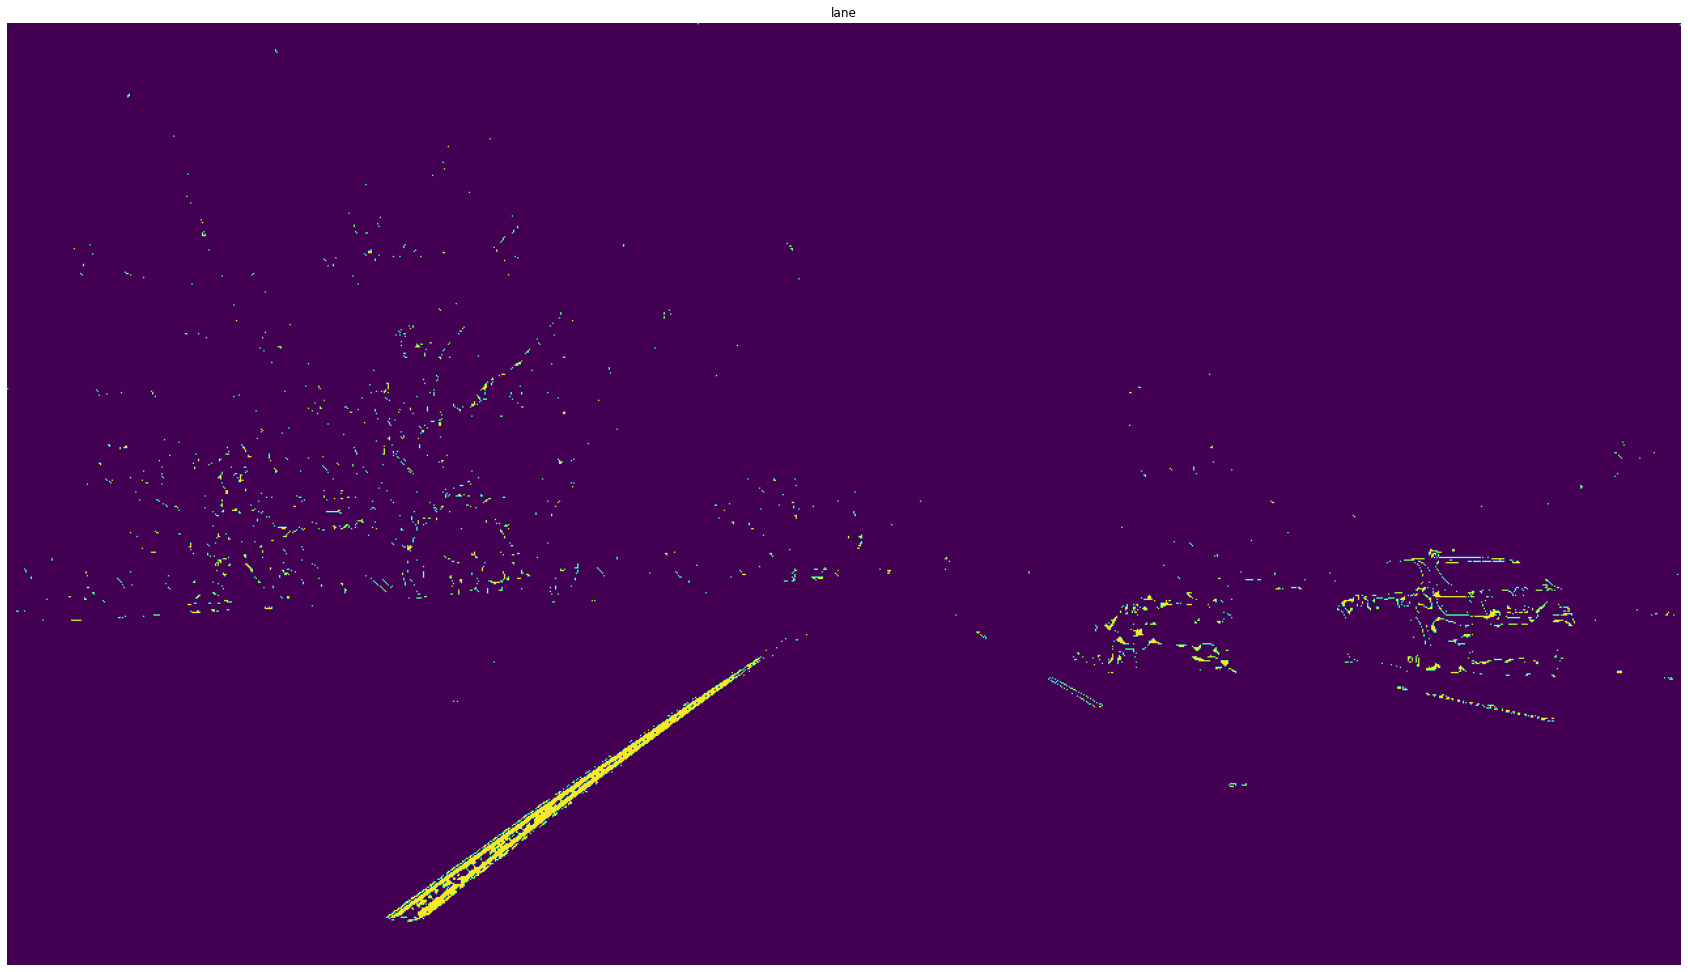

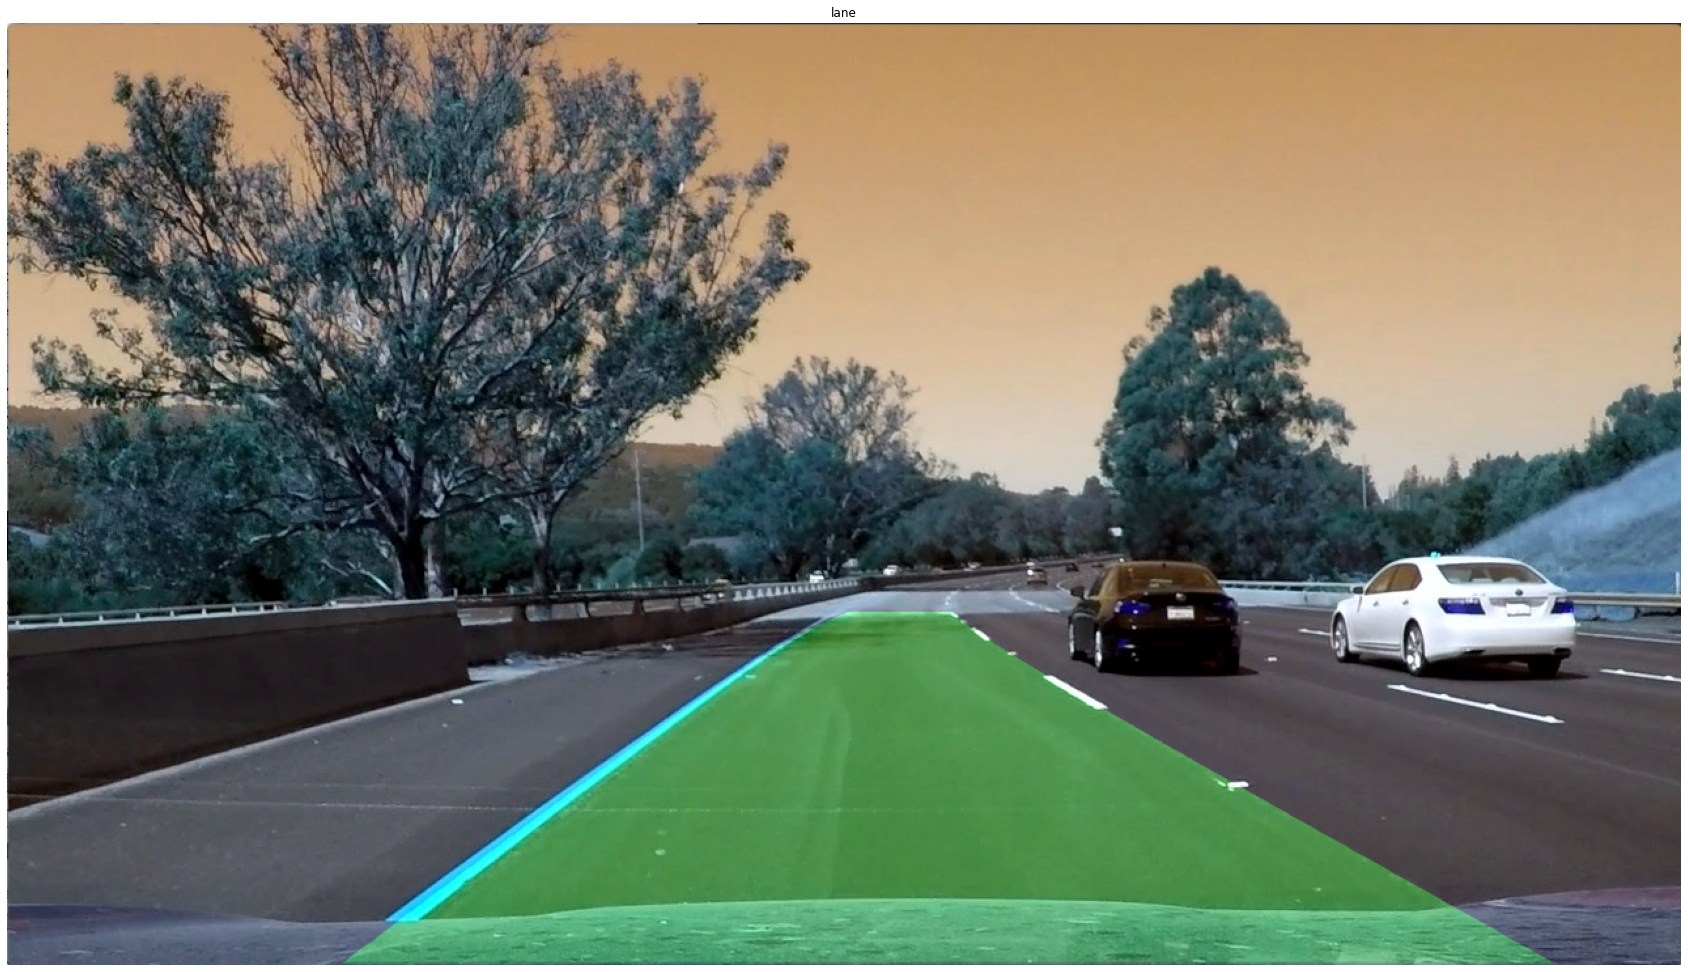

In [40]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
m_inv = cv2.getPerspectiveTransform(dst, src)
m = cv2.getPerspectiveTransform(src, dst)


def abs_sobel_threshold(img, orient='x', thresh_min=5, thresh_max=100000):
    
    #利用X，y方向上sobel，二值化图像######
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    
    ######二值图像，大于最小阈值并且小于最大阈值的区间置为255， 其余为0，可通过修改最大最小值查看差异
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1  

    return binary_output


def mag_threshold(img, sobel_kernel=3, mag_threshold=(2, 1000)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    ######根据x方向的sobel算子和y方向上sobel算子，计算梯度，公式为sqrt（x^2 + y ^2）
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    binary_out = np.zeros_like(gradmag)
    ########转换为二值图，最大最小值可调，kernel_size也可以调整看看差异
    binary_out[(gradmag >= mag_threshold[0]) & (gradmag <= mag_threshold[1])] = 1
    

    return binary_out

def dir_threshold(img, sobel_kernel=5, thresh=(0, np.pi/3.15)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #####根据x方向的sobel算子和y方向上sobel算子，计算角度，公式为arctan（y/x），将倾斜角度过大的过滤掉 
    absgraddir = np.arctan(sobely / sobelx)
    binary_output = np.zeros_like(absgraddir)
    
    #####转换为二值图，最大最小值可调，kernel_size也可以调整看看差异
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def hls_thresh(img, thresh=(40, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #####分离出s通道s_channel
    h,l,s_channel = cv2.split(hls)
    binary_output = np.zeros_like(s_channel)
    #####转换为二值图，最大最小值可调
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combined_threshold(img):
    abs_bin = abs_sobel_threshold(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_threshold(img, sobel_kernel=3, mag_threshold=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    #####组合四个阈值结果，判定车道线
    combined[((abs_bin == 1) | (mag_bin == 1) | (dir_bin == 1)) & hls_bin == 1]=255
    #combined[((abs_bin == 1) | (mag_bin == 1)) | ((dir_bin == 1) & (hls_bin == 1))]=1 
    
    return combined, abs_bin, mag_bin, dir_bin, hls_bin

def line_fit_and_draw_line(binary_warped):
    # "查找拟合直线"
    # 对图像对下半部分查找直方图
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype('uint8')

    #查找直方图中左右两侧对峰值
    midpoint = np.int(histogram.shape[0] / 2)
    
    #左侧从100到 midpoint的最大值，转换成图像坐标还要加上100哦～############
    #右侧从midpoint到图像宽度减100的最大值，转换成图像坐标还要加上midpoint哦～############
    ####也就是图像左右边缘100像素内不查找车道线##################
    
    #####查找左侧右侧最大值基本点
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    ##########以下是关于滑动窗口查找车道线的代码#####################
    nwindows = 9
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 10

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    ##########以上是关于滑动窗口查找车道线的代码#####################
    
    
    ######将左侧，右侧车道线3次拟合，用函数np.polyfit
    left_fit = np.polyfit(lefty, leftx,2)
    right_fit = np.polyfit(righty, rightx,2)
    #####在图上画出拟合的线
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    
    #####对y进行拟合，x = a * y ^ 2 + b * y + C
    left_fitx = left_fit[0]*ploty**2+ left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2+ right_fit[1]*ploty + right_fit[2]
    
    #####生成一张黑图，做mask，将车道线区域标注出来
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # 在透射变换后的图上画出车道线
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    

    # 将画出的车道线的图，逆变换到原来的图上，将color_warp逆变换为newwarp
    newwarp = cv2.warpPerspective(color_warp, m_inv, (img.shape[1], img.shape[0]))
    
    
    # 将原来的图和标注好车道线的图叠加，用cv2.addWeighted，可画成半透明，最终图为result
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    plt.figure(figsize = (30, 30))
    plt.title('lane')
    plt.subplot(1, 1, 1)
    plt.imshow(result)
    plt.axis('off')
    
    return result

imgs = glob.glob("testImage/test*")
for per in imgs:
    dir, name = os.path.split(per)
    img = cv2.imread(per)
    imgOut, abs_bin, mab_bin, dir_bin, hls_bin = combined_threshold(img)
    cv2.imwrite("test_image_undistort_feature/" + name, imgOut)
    plt.imshow(imgOut)
    imgOut_size = (imgOut.shape[1], imgOut.shape[0])
    binary_warped = cv2.warpPerspective(imgOut, m, imgOut_size, flags=cv2.INTER_LINEAR)
    result = line_fit_and_draw_line(binary_warped)
    cv2.imwrite("test_image_undistort_feature_result/" + name, result)

    
'''
img = cv2.imread("./testImage/test6.jpg")
out1 = mag_threshold(img)
out2 = abs_sobel_threshold(img)
out3 = dir_threshold(img)
out4 = hls_thresh(img)
imgOut, abs_bin, mab_bin, dir_bin, hls_bin = combined_threshold(img)
plt.figure(figsize = (30, 30))
plt.title('calibration')
plt.subplot(1, 5, 1)
plt.imshow(out1)
plt.subplot(1, 5, 2)
plt.imshow(out2)
plt.subplot(1, 5, 3)
plt.imshow(out3)
plt.subplot(1, 5, 4)
plt.imshow(out4)
plt.subplot(1, 5, 5)
plt.imshow(imgOut)
plt.axis('off')
imgOut_size = (imgOut.shape[1], imgOut.shape[0])
binary_warped = cv2.warpPerspective(imgOut, m, imgOut_size, flags=cv2.INTER_LINEAR)
undist = cv2.imread('undist6.jpg')
line_fit_and_draw_line(binary_warped)
'''